In [1]:
!pip3 install datasets
!wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.0 MB/s eta 0:00:00
--2024-03-16 03:52:00--  https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7502 (7.3K) [text/plain]
Saving to: ‘conlleval.py’

conlleval.py        100%[===================>]   7.33K  --.-KB/s    in 0s      

2024-03-16 03:52:00 (96.5 MB/s) - ‘conlleval.py’ saved [7502/7502]



In [36]:
!pip install presidio-analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 39.2 MB/s eta 0:00:00


In [38]:
!pip install flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 67.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 k

In [19]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import os
import keras
import numpy as np
import tensorflow as tf
from keras import layers
from datasets import load_dataset
from collections import Counter
from conlleval import evaluate

import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt

from transformers import AutoModel, AutoTokenizer

import logging
from typing import Optional, List, Tuple, Set
from presidio_analyzer import (
    RecognizerResult,
    EntityRecognizer,
    AnalysisExplanation,
)
from presidio_analyzer.nlp_engine import NlpArtifacts

from flair.data import Sentence
from flair.models import SequenceTagger


In [4]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [5]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

In [6]:
class NERModel(keras.Model):
    def __init__(
        self, num_tags, vocab_size, maxlen=128, embed_dim=32, num_heads=2, ff_dim=32
    ):
        super().__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.dropout1 = layers.Dropout(0.1)
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.dropout2 = layers.Dropout(0.1)
        self.ff_final = layers.Dense(num_tags, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.transformer_block(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.dropout2(x, training=training)
        x = self.ff_final(x)
        return x

In [7]:
conll_data = load_dataset("conll2003")


In [8]:
def dataset_to_dataframe(dataset):
    data_dict = {key: dataset[key] for key in dataset.features}
    return pd.DataFrame(data_dict)

# Combine all splits (train, validation, test) into a single DataFrame
conll_df = pd.concat([dataset_to_dataframe(conll_data[split]) for split in conll_data.keys()])

In [7]:
csv_file_path = "conll_data.csv"
conll_df.to_csv(csv_file_path, index=False)

# Download the CSV file to local machine

files.download(csv_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
print(conll_df.head())

  id                                             tokens  \
0  0  [EU, rejects, German, call, to, boycott, Briti...   
1  1                                 [Peter, Blackburn]   
2  2                             [BRUSSELS, 1996-08-22]   
3  3  [The, European, Commission, said, on, Thursday...   
4  4  [Germany, 's, representative, to, the, Europea...   

                                            pos_tags  \
0                [22, 42, 16, 21, 35, 37, 16, 21, 7]   
1                                           [22, 22]   
2                                           [22, 11]   
3  [12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...   
4  [22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...   

                                          chunk_tags  \
0                [11, 21, 11, 12, 21, 22, 11, 12, 0]   
1                                           [11, 12]   
2                                           [11, 12]   
3  [11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...   
4  [11, 11, 12, 13, 11, 12, 

In [10]:
print(conll_df.describe())

           id        tokens  pos_tags chunk_tags ner_tags
count   20744         20744     20744      20744    20744
unique  14041         18731     13126      11282     8047
top         0  [Scorers, :]  [22, 11]   [11, 12]   [5, 0]
freq        3            30       611       1290      955


In [11]:
print(conll_df.dtypes)

id            object
tokens        object
pos_tags      object
chunk_tags    object
ner_tags      object
dtype: object


In [12]:
print(conll_df.isnull().sum())

id            0
tokens        0
pos_tags      0
chunk_tags    0
ner_tags      0
dtype: int64


In [13]:
label_counts = conll_df['ner_tags'].value_counts()
print(label_counts)

[5, 0]                                                                                                                                                 955
[3, 0, 0, 0, 0, 0, 0, 0]                                                                                                                               663
[0, 1, 2, 0, 5, 0, 0]                                                                                                                                  582
[0, 0]                                                                                                                                                 409
[3, 0, 3, 0]                                                                                                                                           352
                                                                                                                                                      ... 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]                      

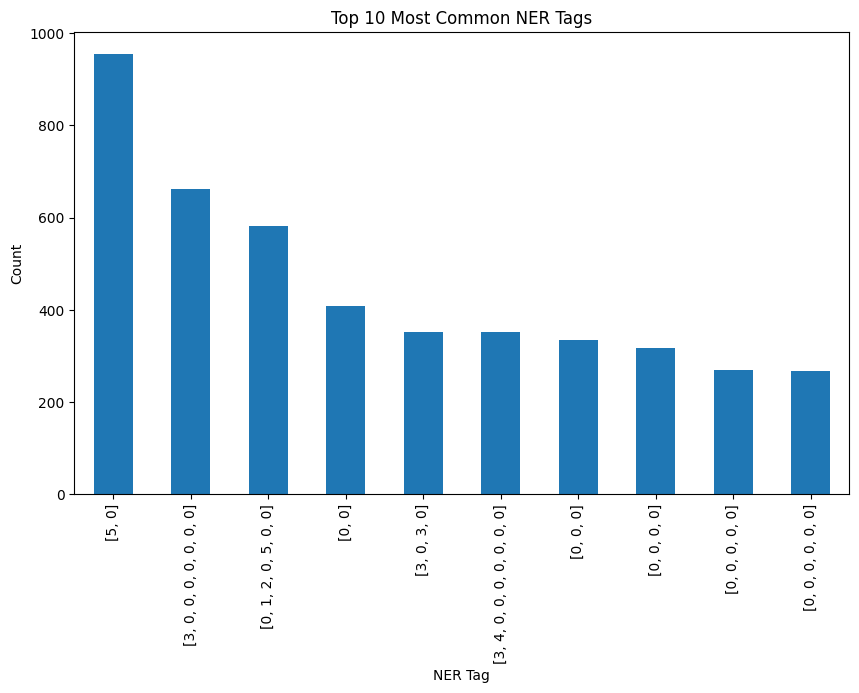

In [14]:
top_10_labels = label_counts.head(10)

# Plot the distribution of the top 10 NER tags
plt.figure(figsize=(10, 6))
top_10_labels.plot(kind='bar')
plt.title('Top 10 Most Common NER Tags')
plt.xlabel('NER Tag')
plt.ylabel('Count')
plt.show()


In [9]:
def export_to_file(export_file_path, data):
    with open(export_file_path, "w") as f:
        for record in data:
            ner_tags = record["ner_tags"]
            tokens = record["tokens"]
            if len(tokens) > 0:
                f.write(
                    str(len(tokens))
                    + "\t"
                    + "\t".join(tokens)
                    + "\t"
                    + "\t".join(map(str, ner_tags))
                    + "\n"
                )


os.makedirs("data", exist_ok=True)
export_to_file("./data/conll_train.txt", conll_data["train"])
export_to_file("./data/conll_val.txt", conll_data["validation"])

In [10]:
def make_tag_lookup_table():
    iob_labels = ["B", "I"]
    ner_labels = ["PER", "ORG", "LOC", "MISC"]
    all_labels = [(label1, label2) for label2 in ner_labels for label1 in iob_labels]
    all_labels = ["-".join([a, b]) for a, b in all_labels]
    all_labels = ["[PAD]", "O"] + all_labels
    return dict(zip(range(0, len(all_labels) + 1), all_labels))


mapping = make_tag_lookup_table()
print(mapping)

{0: '[PAD]', 1: 'O', 2: 'B-PER', 3: 'I-PER', 4: 'B-ORG', 5: 'I-ORG', 6: 'B-LOC', 7: 'I-LOC', 8: 'B-MISC', 9: 'I-MISC'}


In [11]:
all_tokens = sum(conll_data["train"]["tokens"], [])
all_tokens_array = np.array(list(map(str.lower, all_tokens)))

counter = Counter(all_tokens_array)
print(len(counter))

num_tags = len(mapping)
vocab_size = 20000

# We only take (vocab_size - 2) most commons words from the training data since
# the `StringLookup` class uses 2 additional tokens - one denoting an unknown
# token and another one denoting a masking token
vocabulary = [token for token, count in counter.most_common(vocab_size - 2)]

# The StringLook class will convert tokens to token IDs
lookup_layer = keras.layers.StringLookup(vocabulary=vocabulary)

21009


In [12]:
train_data = tf.data.TextLineDataset("./data/conll_train.txt")
val_data = tf.data.TextLineDataset("./data/conll_val.txt")

In [13]:
print(list(train_data.take(1).as_numpy_iterator()))


[b'9\tEU\trejects\tGerman\tcall\tto\tboycott\tBritish\tlamb\t.\t3\t0\t7\t0\t0\t0\t7\t0\t0']


In [14]:
def map_record_to_training_data(record):
    record = tf.strings.split(record, sep="\t")
    length = tf.strings.to_number(record[0], out_type=tf.int32)
    tokens = record[1 : length + 1]
    tags = record[length + 1 :]
    tags = tf.strings.to_number(tags, out_type=tf.int64)
    tags += 1
    return tokens, tags


def lowercase_and_convert_to_ids(tokens):
    tokens = tf.strings.lower(tokens)
    return lookup_layer(tokens)


# We use `padded_batch` here because each record in the dataset has a
# different length.
batch_size = 32
train_dataset = (
    train_data.map(map_record_to_training_data)
    .map(lambda x, y: (lowercase_and_convert_to_ids(x), y))
    .padded_batch(batch_size)
)
val_dataset = (
    val_data.map(map_record_to_training_data)
    .map(lambda x, y: (lowercase_and_convert_to_ids(x), y))
    .padded_batch(batch_size)
)

ner_model = NERModel(num_tags, vocab_size, embed_dim=32, num_heads=4, ff_dim=64)

In [15]:
class CustomNonPaddingTokenLoss(keras.losses.Loss):
    def __init__(self, name="custom_ner_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=False, reduction= 'none'
        )
        loss = loss_fn(y_true, y_pred)
        mask = tf.cast((y_true > 0), dtype=tf.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


loss = CustomNonPaddingTokenLoss()

In [16]:
ner_model.compile(optimizer="adam", loss=loss)
ner_model.fit(train_dataset, epochs=10)


def tokenize_and_convert_to_ids(text):
    tokens = text.split()
    return lowercase_and_convert_to_ids(tokens)


# Sample inference using the trained model
sample_input = tokenize_and_convert_to_ids(
    "eu rejects german call to boycott british lamb"
)
sample_input = tf.reshape(sample_input, shape=[1, -1])
print(sample_input)

output = ner_model.predict(sample_input)
prediction = np.argmax(output, axis=-1)[0]
prediction = [mapping[i] for i in prediction]

# eu -> B-ORG, german -> B-MISC, british -> B-MISC
print(prediction)


Epoch 1/10
439/439 [==============================] - 20s 38ms/step - loss: 0.6150
Epoch 2/10
439/439 [==============================] - 17s 38ms/step - loss: 0.2667
Epoch 3/10
439/439 [==============================] - 14s 33ms/step - loss: 0.1617
Epoch 4/10
439/439 [==============================] - 15s 33ms/step - loss: 0.1254
Epoch 5/10
439/439 [==============================] - 14s 33ms/step - loss: 0.1015
Epoch 6/10
439/439 [==============================] - 14s 32ms/step - loss: 0.0837
Epoch 7/10
439/439 [==============================] - 15s 35ms/step - loss: 0.0697
Epoch 8/10
439/439 [==============================] - 14s 32ms/step - loss: 0.0604
Epoch 9/10
439/439 [==============================] - 15s 33ms/step - loss: 0.0526
Epoch 10/10
439/439 [==============================] - 16s 35ms/step - loss: 0.0456
tf.Tensor([[  988 10950   204   628     6  3938   215  5773]], shape=(1, 8), dtype=int64)
1/1 [==============================] - 0s 261ms/step
['B-ORG', 'O', 'B-MISC', '

In [17]:
def calculate_metrics(dataset):
    all_true_tag_ids, all_predicted_tag_ids = [], []

    for x, y in dataset:
        output = ner_model.predict(x, verbose=0)
        predictions = np.argmax(output, axis=-1)
        predictions = np.reshape(predictions, [-1])

        true_tag_ids = np.reshape(y, [-1])

        mask = (true_tag_ids > 0) & (predictions > 0)
        true_tag_ids = true_tag_ids[mask]
        predicted_tag_ids = predictions[mask]

        all_true_tag_ids.append(true_tag_ids)
        all_predicted_tag_ids.append(predicted_tag_ids)

    all_true_tag_ids = np.concatenate(all_true_tag_ids)
    all_predicted_tag_ids = np.concatenate(all_predicted_tag_ids)

    predicted_tags = [mapping[tag] for tag in all_predicted_tag_ids]
    real_tags = [mapping[tag] for tag in all_true_tag_ids]

    evaluate(real_tags, predicted_tags)


calculate_metrics(val_dataset)

processed 51362 tokens with 5942 phrases; found: 5194 phrases; correct: 3847.
accuracy:  62.20%; (non-O)
accuracy:  93.33%; precision:  74.07%; recall:  64.74%; FB1:  69.09
              LOC: precision:  85.18%; recall:  79.48%; FB1:  82.23  1714
             MISC: precision:  75.61%; recall:  63.88%; FB1:  69.25  779
              ORG: precision:  63.88%; recall:  60.92%; FB1:  62.37  1279
              PER: precision:  68.99%; recall:  53.26%; FB1:  60.11  1422


In [18]:
def test_model_with_input(ner_model, mapping):
    # Get input sentence from user
    input_sentence = input("Enter a sentence: ")

    # Tokenize and convert input sentence to IDs
    sample_input = tokenize_and_convert_to_ids(input_sentence)
    sample_input = tf.reshape(sample_input, shape=[1, -1])

    # Predict tags using the trained model
    output = ner_model.predict(sample_input)
    predictions = np.argmax(output, axis=-1)[0]
    predicted_tags = [mapping[i] for i in predictions]

    # Print the predicted tags for each token in the input sentence
    print("Input sentence:", input_sentence)
    print("Predicted tags:", predicted_tags)

# Test the model with user input
test_model_with_input(ner_model, mapping)

Enter a sentence: My Name is Karishma. I live in Canada. Canada I am from India
1/1 [==============================] - 0s 20ms/step
Input sentence: My Name is Karishma. I live in Canada. Canada I am from India
Predicted tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'B-LOC']


In [20]:
logger = logging.getLogger("presidio-analyzer")


class FlairRecognizer(EntityRecognizer):
    """
    Wrapper for a flair model, if needed to be used within Presidio Analyzer.
    :example:
    >from presidio_analyzer import AnalyzerEngine, RecognizerRegistry
    >flair_recognizer = FlairRecognizer()
    >registry = RecognizerRegistry()
    >registry.add_recognizer(flair_recognizer)
    >analyzer = AnalyzerEngine(registry=registry)
    >results = analyzer.analyze(
    >    "My name is Christopher and I live in Irbid.",
    >    language="en",
    >    return_decision_process=True,
    >)
    >for result in results:
    >    print(result)
    >    print(result.analysis_explanation)
    """

    ENTITIES = [
        "LOCATION",
        "PERSON",
        "ORGANIZATION",
        # "MISCELLANEOUS"   # - There are no direct correlation with Presidio entities.
    ]

    DEFAULT_EXPLANATION = "Identified as {} by Flair's Named Entity Recognition"

    CHECK_LABEL_GROUPS = [
        ({"LOCATION"}, {"LOC", "LOCATION"}),
        ({"PERSON"}, {"PER", "PERSON"}),
        ({"ORGANIZATION"}, {"ORG"}),
        # ({"MISCELLANEOUS"}, {"MISC"}), # Probably not PII
    ]

    MODEL_LANGUAGES = {"en": "flair/ner-english-large"}

    PRESIDIO_EQUIVALENCES = {
        "PER": "PERSON",
        "LOC": "LOCATION",
        "ORG": "ORGANIZATION",
        # 'MISC': 'MISCELLANEOUS'   # - Probably not PII
    }

    def __init__(
        self,
        supported_language: str = "en",
        supported_entities: Optional[List[str]] = None,
        check_label_groups: Optional[Tuple[Set, Set]] = None,
        model: SequenceTagger = None,
        model_path: Optional[str] = None,
    ):
        self.check_label_groups = (
            check_label_groups if check_label_groups else self.CHECK_LABEL_GROUPS
        )

        supported_entities = supported_entities if supported_entities else self.ENTITIES

        if model and model_path:
            raise ValueError("Only one of model or model_path should be provided.")
        elif model and not model_path:
            self.model = model
        elif not model and model_path:
            print(f"Loading model from {model_path}")
            self.model = SequenceTagger.load(model_path)
        else:
            print(f"Loading model for language {supported_language}")
            self.model = SequenceTagger.load(
                self.MODEL_LANGUAGES.get(supported_language)
            )

        super().__init__(
            supported_entities=supported_entities,
            supported_language=supported_language,
            name="Flair Analytics",
        )

    def load(self) -> None:
        """Load the model, not used. Model is loaded during initialization."""
        pass

    def get_supported_entities(self) -> List[str]:
        """
        Return supported entities by this model.
        :return: List of the supported entities.
        """
        return self.supported_entities

    # Class to use Flair with Presidio as an external recognizer.
    def analyze(
        self, text: str, entities: List[str], nlp_artifacts: NlpArtifacts = None
    ) -> List[RecognizerResult]:
        """
        Analyze text using Text Analytics.
        :param text: The text for analysis.
        :param entities: Not working properly for this recognizer.
        :param nlp_artifacts: Not used by this recognizer.
        :param language: Text language. Supported languages in MODEL_LANGUAGES
        :return: The list of Presidio RecognizerResult constructed from the recognized
            Flair detections.
        """

        results = []

        sentences = Sentence(text)
        self.model.predict(sentences)

        # If there are no specific list of entities, we will look for all of it.
        if not entities:
            entities = self.supported_entities

        for entity in entities:
            if entity not in self.supported_entities:
                continue

            for ent in sentences.get_spans("ner"):
                if not self.__check_label(
                    entity, ent.labels[0].value, self.check_label_groups
                ):
                    continue
                textual_explanation = self.DEFAULT_EXPLANATION.format(
                    ent.labels[0].value
                )
                explanation = self.build_flair_explanation(
                    round(ent.score, 2), textual_explanation
                )
                flair_result = self._convert_to_recognizer_result(ent, explanation)

                results.append(flair_result)

        return results

    def _convert_to_recognizer_result(self, entity, explanation) -> RecognizerResult:
        entity_type = self.PRESIDIO_EQUIVALENCES.get(entity.tag, entity.tag)
        flair_score = round(entity.score, 2)

        flair_results = RecognizerResult(
            entity_type=entity_type,
            start=entity.start_position,
            end=entity.end_position,
            score=flair_score,
            analysis_explanation=explanation,
        )

        return flair_results

    def build_flair_explanation(
        self, original_score: float, explanation: str
    ) -> AnalysisExplanation:
        """
        Create explanation for why this result was detected.
        :param original_score: Score given by this recognizer
        :param explanation: Explanation string
        :return:
        """
        explanation = AnalysisExplanation(
            recognizer=self.__class__.__name__,
            original_score=original_score,
            textual_explanation=explanation,
        )
        return explanation

    @staticmethod
    def __check_label(
        entity: str, label: str, check_label_groups: Tuple[Set, Set]
    ) -> bool:
        return any(
            [entity in egrp and label in lgrp for egrp, lgrp in check_label_groups]
        )

In [21]:
from transformers import AutoModel, AutoTokenizer


if __name__ == "__main__":
    from flair.data import Sentence
    from flair.models import SequenceTagger

    # load tagger
    tagger = SequenceTagger.load("flair/ner-english-large")

    # make example sentence
    sentence = Sentence("My name is Karishma Shirsath. I live in Toronto Canada.")

    # predict NER tags
    tagger.predict(sentence)

    # print sentence
    print(sentence)

    # print predicted NER spans
    print("The following NER tags are found:")
    # iterate over entities and print
    for entity in sentence.get_spans("ner"):
        print(entity)



2024-03-16 05:24:49,993 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>
Sentence[12]: "My name is Karishma Shirsath. I live in Toronto Canada." → ["Karishma Shirsath"/PER, "Toronto"/LOC, "Canada"/LOC]
The following NER tags are found:
Span[3:5]: "Karishma Shirsath" → PER (1.0)
Span[9:10]: "Toronto" → LOC (1.0)
Span[10:11]: "Canada" → LOC (1.0)


In [33]:
if __name__ == "__main__":
    from flair.data import Sentence
    from flair.models import SequenceTagger

    # load tagger
    tagger = SequenceTagger.load("flair/ner-english-large")

    # make example sentence
    sentence = Sentence("My name is Karishma Shirsath. I live in Toronto Canada.")

    # predict NER tags
    tagger.predict(sentence)

    # print sentence
    print(sentence)

    # Anonymize identified named entities
    anonymized_sentence = str(sentence)
    for entity in sentence.get_spans("ner"):
        entity_text = entity.text
        anonymized_text = "*" * len(entity_text)
        anonymized_sentence = anonymized_sentence.replace(entity_text, anonymized_text)

    # print anonymized sentence
    print("Anonymized sentence:")
    print(anonymized_sentence)



2024-03-16 05:39:00,757 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>
Sentence[12]: "My name is Karishma Shirsath. I live in Toronto Canada." → ["Karishma Shirsath"/PER, "Toronto"/LOC, "Canada"/LOC]
Anonymized sentence:
Sentence[12]: "My name is *****************. I live in ******* ******." → ["*****************"/PER, "*******"/LOC, "******"/LOC]
